# CYBERML – Analyse du CIC IoT-DIAD 2024

Ce notebook conçoit et évalue une chaîne de traitement batch pour **(i)** la détection d’anomalies (non supervisée) et **(ii)** la classification d’attaques (supervisée), à partir de caractéristiques de flux réseau (flow-based).


## 1. Introduction

Objectif : construire un pipeline reproductible pour des données de flux en cybersécurité, comparer **3 algorithmes non supervisés** et **3 algorithmes supervisés**, et rapporter les métriques requises :
- Matrice de confusion, Précision, Rappel, AUPRC, Balanced accuracy, MCC.

On commence en binaire (**Benign vs Attack**) puis on augmente progressivement la diversité des attaques.


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    average_precision_score,
    balanced_accuracy_score,
    matthews_corrcoef,
	accuracy_score,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

BASE_DIR = "./Device_Identification_Anomaly_Detection-Packet_Based_Features"
TARGET_FAMILIES = ["Benign", "BruteForce", "DDoS", "DoS", "Mirai", "Recon", "Spoofing", "Web-Based"]
DROP_CANDIDATES = {"Flow ID","Src IP","Dst IP","Src Port","Dst Port","Timestamp","Unnamed: 0"}
DROP_PATTERNS = ["source ip", "destination ip", "src ip", "dst ip", "port", "timestamp", "flow id"]
CANONICAL_FAMILY = {
    "benign": "Benign",
    "benigntraffic": "Benign",
    "ddos": "DDoS",
    "dos": "DoS",
    "mirai": "Mirai",
    "recon": "Recon",
    "spoofing": "Spoofing",
    "webbased": "Web-Based",
    "bruteforce": "BruteForce",
}

MAX_ROWS_PER_FILE = 10_000
MAX_ROWS_PER_FAMILY = 60_000
MAX_ROWS_TOTAL = 300_000
MIN_SAMPLES_PER_SUBTYPE = 1_000

## 2. Jeu de données et protocole expérimental

Jeu de données : **CIC IoT-DIAD 2024 – Anomaly Detection (Flow Based Features)**.

Dans cette version du notebook, on utilise **toutes les attaques** disponibles (dans la limite de budgets RAM-safe) :
- Benign
- BruteForce
- DDoS
- DoS
- Mirai
- Recon
- Spoofing
- Web-Based

Point critique : le split train/test est fait **par fichier (group split)** pour éviter la fuite de données (flows très similaires d’un même PCAP en train et en test).


In [26]:
def should_drop(col: str) -> bool:
    name = col.strip()
    low = name.lower()
    if name in DROP_CANDIDATES and any(p in low for p in DROP_PATTERNS):
        return True
    return False

def infer_family_subtype(csv_path: str):
    rel = os.path.relpath(csv_path, BASE_DIR)
    parts = rel.split(os.sep)
    key = "".join(ch for ch in parts[0].lower() if ch.isalnum())
    family = CANONICAL_FAMILY.get(key, parts[0])
    subtype = parts[1] if len(parts) >= 3 else family
    return family, subtype

def list_all_flow_csvs():
    paths = []
    for root, _, files in os.walk(BASE_DIR):
        for f in files:
            if f.endswith(".csv"):
                paths.append(os.path.join(root, f))
    return sorted(paths)

def load_all_flows_ram_safe(feature_cols: list[str], chunksize: int = 200_000):
    by_family: dict[str, list[str]] = {f: [] for f in TARGET_FAMILIES}
    for p in list_all_flow_csvs():
        fam, _ = infer_family_subtype(p)
        if fam in by_family:
            by_family[fam].append(p)
    frames = []
    loaded_total = 0
    loaded_by_family = {f: 0 for f in TARGET_FAMILIES}
    cursors = {f: 0 for f in TARGET_FAMILIES}
    while loaded_total < MAX_ROWS_TOTAL:
        progressed = False
        for fam in TARGET_FAMILIES:
            if loaded_total >= MAX_ROWS_TOTAL:
                break
            if MAX_ROWS_PER_FAMILY - loaded_by_family[fam] <= 0 or  MAX_ROWS_TOTAL - loaded_total <= 0:
                continue
            paths = by_family.get(fam, [])
            cur = cursors[fam]
            if cur >= len(paths):
                continue
            p = paths[cur]
            cursors[fam] = cur + 1
            fam2, sub = infer_family_subtype(p)
            group = os.path.relpath(p, BASE_DIR)
            usecols = [c for c in feature_cols if c in set(pd.read_csv(p, nrows=0).columns)]
            if not usecols:
                continue
            chunks = []
            kept = 0
            for chunk in pd.read_csv(p, usecols=usecols, chunksize=chunksize, low_memory=False):
                for c in chunk.columns:
                    chunk[c] = pd.to_numeric(chunk[c], errors="coerce")
                chunk = chunk.replace([np.inf, -np.inf], np.nan)
                chunk = chunk.dropna(axis=0, how="all")
                chunk = chunk.astype(np.float32)
                remaining = min(MAX_ROWS_PER_FILE, MAX_ROWS_PER_FAMILY - loaded_by_family[fam],  MAX_ROWS_TOTAL - loaded_total) - kept
                if remaining <= 0:
                    break
                if len(chunk) > remaining:
                    chunk = chunk.sample(n=remaining, random_state=RANDOM_STATE)
                kept += len(chunk)

                chunk["attack_family"] = fam2
                chunk["attack_subtype"] = sub
                chunk["group"] = group
                chunks.append(chunk)
                if kept >= min(MAX_ROWS_PER_FILE, MAX_ROWS_PER_FAMILY - loaded_by_family[fam],  MAX_ROWS_TOTAL - loaded_total):
                    break
            if not chunks:
                continue
            dfp = pd.concat(chunks, ignore_index=True)
            for c in [c for c in feature_cols if c not in dfp.columns]:
                dfp[c] = np.nan
            if len(dfp) == 0:
                continue
            frames.append(dfp)
            loaded_total += len(dfp)
            loaded_by_family[fam2] += len(dfp)
            progressed = True
        if not progressed:
            break
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

def eval_binary(y_true, y_pred, y_score, title):
    cm = confusion_matrix(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auprc = average_precision_score(y_true, y_score)
    return {
        "title": title,
        "cm": cm,
        "precision": float(prec),
        "recall": float(rec),
        "auprc": float(auprc),
        "balanced_acc": float(bal_acc),
        "mcc": float(mcc),
    }

def eval_multiclass(y_true, y_pred, title, y_proba=None, classes=None):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
    prec_w = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec_w = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    auprc_macro = None
    Y = label_binarize(y_true, classes=classes)
    present = Y.sum(axis=0) > 0
    if present.any():
        auprc_macro = average_precision_score(Y[:, present], y_proba[:, present], average="macro")
    return {
        "title": title,
        "cm": cm,
        "prec_macro": float(prec_macro),
        "rec_macro": float(rec_macro),
        "prec_weighted": float(prec_w),
        "rec_weighted": float(rec_w),
        "auprc_macro_ovr": None if auprc_macro is None else float(auprc_macro),
        "balanced_acc": float(bal_acc),
        "mcc": float(mcc),
    }


def plot_confusion_matrix(y_true, y_pred_or_score, title, class_names=None):
    y_arr = np.asarray(y_pred_or_score)
    if y_arr.dtype.kind in "fc" and y_arr.ndim == 1:
        y_pred = (y_arr >= 0.5).astype(int)
    else:
        y_pred = y_pred_or_score

    labels = None
    xticklabels = None
    yticklabels = None
    if class_names is not None:
        labels = np.arange(len(class_names))
        xticklabels = class_names
        yticklabels = class_names

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    figsize = (4, 4) if class_names is None or len(class_names) <= 2 else (7, 6)

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=xticklabels,
        yticklabels=yticklabels,
    )
    plt.title(title)
    plt.ylabel("Réel")
    plt.xlabel("Prédit")
    if class_names is not None and len(class_names) > 2:
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
    plt.show()

In [27]:
def prepare_scenario(df_all: pd.DataFrame, feature_cols: list[str], name: str):
    df_used = df_all
    if name == "Binaire":
        classes = ["Benign", "Attack"]
        y = (df_used["attack_family"] != "Benign").astype(np.int8).to_numpy()
    elif name == "Familles":
        classes = sorted(df_used["attack_family"].astype(str).unique())
        family_to_id = {f: i for i, f in enumerate(classes)}
        y = df_used["attack_family"].map(family_to_id).astype(np.int16).to_numpy()
    else:
        df_used = df_all.copy()
        df_used.loc[df_used["attack_family"] == "Benign", "attack_subtype"] = "Benign"
        sub_counts = df_used["attack_subtype"].value_counts()
        kept = sub_counts[sub_counts >= MIN_SAMPLES_PER_SUBTYPE]
        df_used["subtype_filtered"] = df_used["attack_subtype"].where(df_used["attack_subtype"].isin(kept.index), other="Other")
        classes = sorted(df_used["subtype_filtered"].astype(str).unique())
        subtype_to_id = {s: i for i, s in enumerate(classes)}
        y = df_used["subtype_filtered"].map(subtype_to_id).astype(np.int16).to_numpy()
        
    X_raw = np.nan_to_num(df_used[feature_cols].to_numpy(dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)
    train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    X_train, X_test = X_raw[train_idx], X_raw[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    return {
        "name": name,
        "X_train": X_train_s,
        "X_test": X_test_s,
        "y_train": y_train,
        "y_test": y_test,
        "classes": classes,
    }

all_csvs = list_all_flow_csvs()
all_cols = list(pd.read_csv(all_csvs[0], nrows=0).columns)
drop_cols = [c for c in all_cols if should_drop(c)]
feature_cols_common = [c for c in all_cols if (c not in drop_cols) and c != "Label"]
df_all = load_all_flows_ram_safe(feature_cols=feature_cols_common, chunksize=200_000)

binary_scenario = prepare_scenario(df_all, feature_cols_common, name="Binaire")
family_scenario = prepare_scenario(df_all, feature_cols_common, name="Familles")
st_scenario = prepare_scenario(df_all, feature_cols_common, name="Sous-types")



## 5. Expériences de détection d’anomalies

Les modèles non supervisés sont entraînés **uniquement sur le trafic Benign** puis évalués sur l’ensemble du test.
On rapporte les métriques et on trace une matrice de confusion (Figure 4).


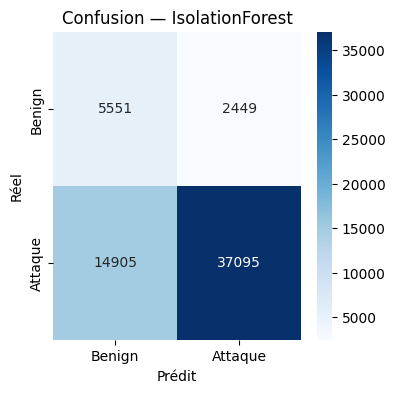

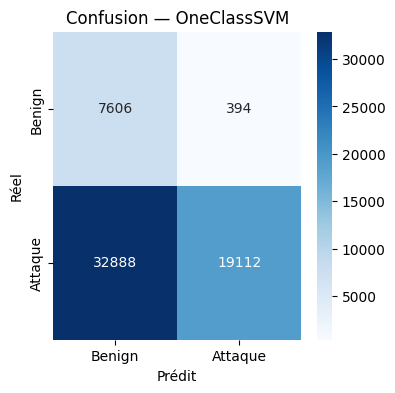

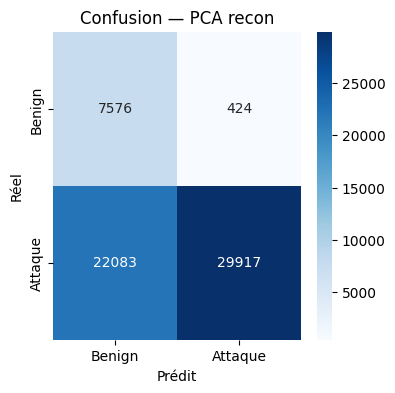

,scenario,title,precision,recall,auprc,balanced_acc,mcc,cm
0,Binaire,Non supervisé - IsolationForest,0.938069,0.713365,0.961366,0.703620,0.292043,"[[5551, 2449], [14905, 37095]]"
1,Binaire,Non supervisé - OneClassSVM,0.979801,0.367538,0.955708,0.659144,0.230987,"[[7606, 394], [32888, 19112]]"
2,Binaire,Non supervisé - Erreur de reconstruction PCA,0.986026,0.575327,0.972224,0.761163,0.355137,"[[7576, 424], [22083, 29917]]"


In [28]:
results = []
artifacts = {}


contam = float(np.clip(float(np.mean(binary_scenario["y_train"])), 0.01, 0.30))
iso = IsolationForest(n_estimators=300, contamination=contam, random_state=RANDOM_STATE, n_jobs=-1)
iso.fit(binary_scenario["X_train"][binary_scenario["y_train"] == 0])
iso_pred = (iso.predict(binary_scenario["X_test"]) == -1).astype(int)
iso_score = -iso.score_samples(binary_scenario["X_test"])


oc = OneClassSVM(kernel="rbf", nu=0.05, gamma="scale")
oc.fit(binary_scenario["X_train"][binary_scenario["y_train"] == 0])
oc_pred = (oc.predict(binary_scenario["X_test"]) == -1).astype(int)
oc_score = -oc.decision_function(binary_scenario["X_test"])


pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
pca.fit(binary_scenario["X_train"][binary_scenario["y_train"] == 0])
recon_error = np.mean((binary_scenario["X_test"] - pca.inverse_transform(pca.transform(binary_scenario["X_test"]))) ** 2, axis=1)
train_recon_error = np.mean((binary_scenario["X_train"][binary_scenario["y_train"] == 0] - pca.inverse_transform(pca.transform(binary_scenario["X_train"][binary_scenario["y_train"] == 0]))) ** 2, axis=1)
pca_pred = (recon_error > np.quantile(train_recon_error, 0.95)).astype(int)





results.append(eval_binary(binary_scenario["y_test"], iso_pred, iso_score, title=f"Non supervisé - IsolationForest"))
results.append(eval_binary(binary_scenario["y_test"], oc_pred, oc_score, title=f"Non supervisé - OneClassSVM"))
results.append(eval_binary(binary_scenario["y_test"], pca_pred, recon_error, title=f"Non supervisé - Erreur de reconstruction PCA"))
for r in results:
	r["scenario"] = binary_scenario["name"]

artifacts["iso_pred"] = iso_pred
artifacts["oc_pred"] = oc_pred
artifacts["pca_pred"] = pca_pred

plot_confusion_matrix(binary_scenario["y_test"], artifacts["iso_pred"],   "Confusion — IsolationForest", class_names=["Benign", "Attaque"])
plot_confusion_matrix(binary_scenario["y_test"], artifacts["oc_pred"],    "Confusion — OneClassSVM", class_names=["Benign", "Attaque"])
plot_confusion_matrix(binary_scenario["y_test"], artifacts["pca_pred"],   "Confusion — PCA recon", class_names=["Benign", "Attaque"])

unsup_df = pd.DataFrame(results)
unsup_df = unsup_df[["scenario", "title", "precision", "recall", "auprc", "balanced_acc", "mcc", "cm"]]
unsup_df


## 6. Expériences de classification supervisée

Les modèles supervisés sont entraînés sur des données labellisées **Benign vs Attack** (toutes attaques chargées dans `df_all`).

Le split est fait **par fichier** (GroupShuffleSplit) pour éviter la fuite.
On trace les matrices de confusion (Figure 4) et les courbes précision–rappel (Figure 5).


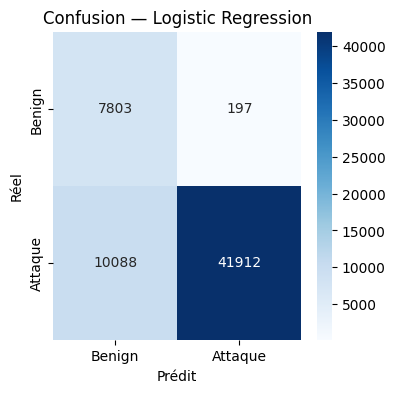

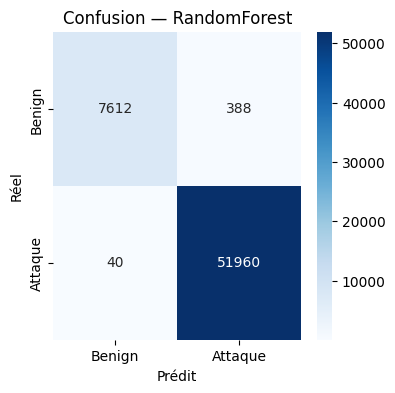

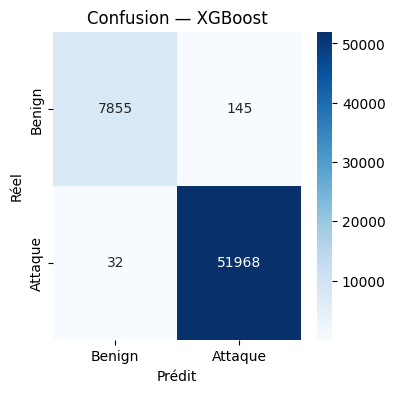

,scenario,title,precision,recall,auprc,balanced_acc,mcc,cm
0,Binaire,Supervisé - Régression logistique,0.995322,0.806000,0.988385,0.890688,0.580633,"[[7803, 197], [10088, 41912]]"
1,Binaire,Supervisé - Forêt aléatoire,0.992588,0.999231,0.999941,0.975365,0.968873,"[[7612, 388], [40, 51960]]"
2,Binaire,Supervisé - XGBoost (CPU hist),0.997218,0.999385,0.999989,0.990630,0.987192,"[[7855, 145], [32, 51968]]"


In [29]:
results = []
artifacts = {}

lr = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)
lr.fit(binary_scenario["X_train"], binary_scenario["y_train"])
lr_pred = lr.predict(binary_scenario["X_test"])
lr_score = lr.predict_proba(binary_scenario["X_test"])[:, 1]


rf = RandomForestClassifier(n_estimators=400,random_state=RANDOM_STATE,n_jobs=-1,class_weight="balanced_subsample")
rf.fit(binary_scenario["X_train"], binary_scenario["y_train"])
rf_pred = rf.predict(binary_scenario["X_test"])
rf_score = rf.predict_proba(binary_scenario["X_test"])[:, 1]


xgb_clf = xgb.XGBClassifier(
	n_estimators=600,
	max_depth=8,
	learning_rate=0.05,
	subsample=0.8,
	colsample_bytree=0.8,
	reg_lambda=1.0,
	min_child_weight=1,
	tree_method="hist",
	eval_metric="logloss",
	random_state=RANDOM_STATE,
	n_jobs=-1,
)
xgb_clf.fit(binary_scenario["X_train"], binary_scenario["y_train"])
xgb_score = xgb_clf.predict_proba(binary_scenario["X_test"])[:, 1]
xgb_pred = (xgb_score >= 0.5).astype(int)



results.append(eval_binary(binary_scenario["y_test"], lr_pred, lr_score, title=f"Supervisé - Régression logistique"))
results.append(eval_binary(binary_scenario["y_test"], rf_pred, rf_score, title=f"Supervisé - Forêt aléatoire"))
results.append(eval_binary(binary_scenario["y_test"], xgb_pred, xgb_score, title=f"Supervisé - XGBoost (CPU hist)"))

artifacts["lr_pred"] = lr_pred
artifacts["rf_pred"] = rf_pred
artifacts["xgb_pred"] = xgb_pred
artifacts["xgb_model"] = xgb_clf

for r in results:
	r["scenario"] = binary_scenario["name"]

plot_confusion_matrix(binary_scenario["y_test"], artifacts["lr_pred"], "Confusion — Logistic Regression", class_names=["Benign", "Attaque"])
plot_confusion_matrix(binary_scenario["y_test"], artifacts["rf_pred"], "Confusion — RandomForest", class_names=["Benign", "Attaque"])
plot_confusion_matrix(binary_scenario["y_test"], artifacts["xgb_pred"], "Confusion — XGBoost", class_names=["Benign", "Attaque"])

sup_df = pd.DataFrame(results)
sup_df = sup_df[["scenario", "title", "precision", "recall", "auprc", "balanced_acc", "mcc", "cm"]]
sup_df


In [30]:
binary_table = pd.concat([unsup_df, sup_df], ignore_index=True)

binary_table = binary_table[[
    "title",
    "precision",
    "recall",
    "auprc",
    "balanced_acc",
    "mcc",
]]

binary_table

,title,precision,recall,auprc,balanced_acc,mcc
0,Non supervisé - IsolationForest,0.938069,0.713365,0.961366,0.703620,0.292043
1,Non supervisé - OneClassSVM,0.979801,0.367538,0.955708,0.659144,0.230987
2,Non supervisé - Erreur de reconstruction PCA,0.986026,0.575327,0.972224,0.761163,0.355137
3,Supervisé - Régression logistique,0.995322,0.806000,0.988385,0.890688,0.580633
4,Supervisé - Forêt aléatoire,0.992588,0.999231,0.999941,0.975365,0.968873
5,Supervisé - XGBoost (CPU hist),0.997218,0.999385,0.999989,0.990630,0.987192


## 6A. Partie 2A — Classification multi-classes (familles)

Objectif : passer de **Benign vs Attack** à un suivi *par familles d’attaques* (≈ 8 classes) pour répondre à l’idée de *tracking attacks*.

Point critique (très important) : éviter la fuite de données. Un split aléatoire par lignes mélange des flows très proches issus d’un même PCAP entre train/test → métriques artificiellement gonflées.



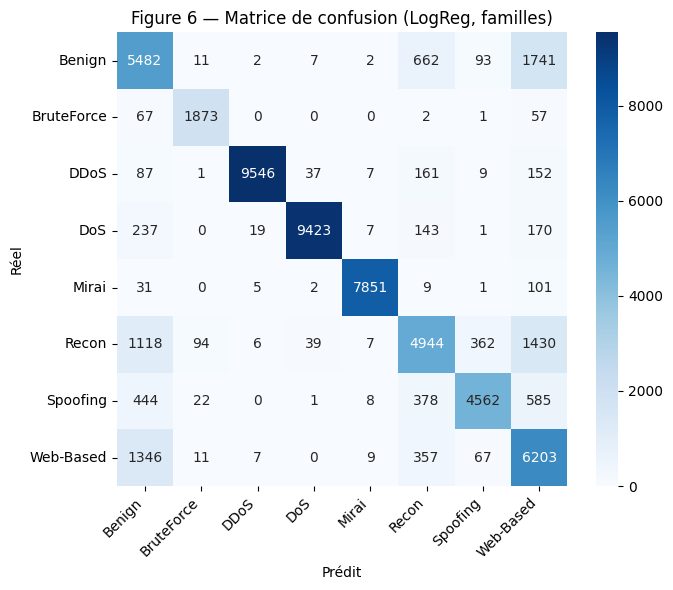

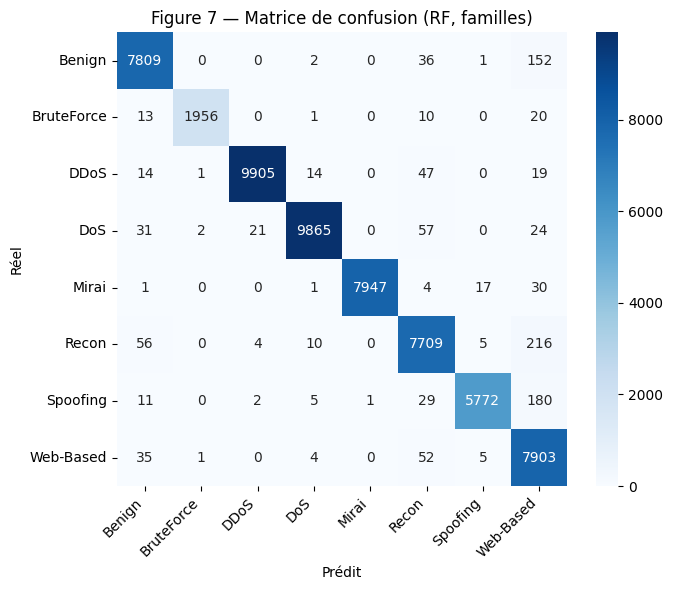

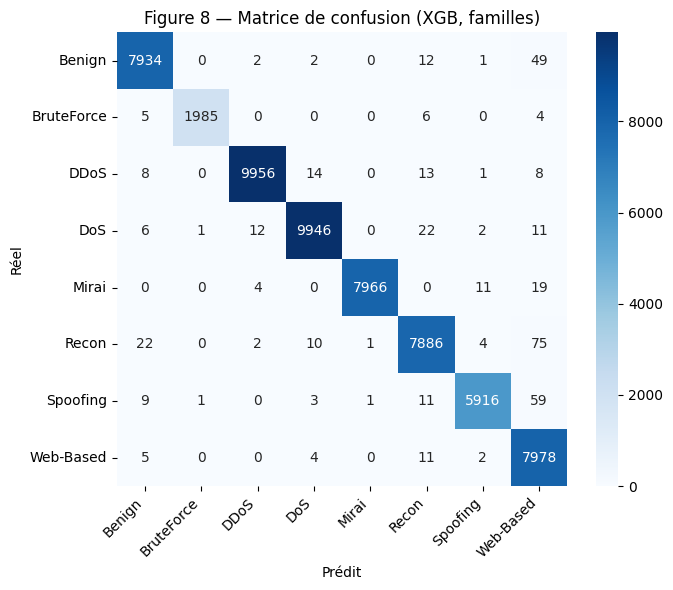

,scenario,title,prec_macro,rec_macro,prec_weighted,rec_weighted,auprc_macro_ovr,balanced_acc,mcc
0,Familles,Multiclass - LogisticRegression,0.845882,0.831717,0.845571,0.831400,0.887887,0.831717,0.805718
1,Familles,Multiclass - RandomForest,0.982718,0.979750,0.981716,0.981100,0.997311,0.979750,0.978134
2,Familles,Multiclass - XGBoost (hist),0.993270,0.992400,0.992863,0.992783,0.999667,0.992400,0.991638


In [32]:
fam_results = []
artifacts = {}



lr = LogisticRegression(max_iter=3000, class_weight="balanced", random_state=RANDOM_STATE)
lr.fit(family_scenario["X_train"], family_scenario["y_train"])
lr_pred = lr.predict(family_scenario["X_test"])
lr_proba = lr.predict_proba(family_scenario["X_test"])


rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced_subsample")
rf.fit(family_scenario["X_train"], family_scenario["y_train"])
rf_pred = rf.predict(family_scenario["X_test"])
rf_proba = rf.predict_proba(family_scenario["X_test"])


xgb_clf = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    objective="multi:softprob",
    num_class=len(family_scenario["classes"]),
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb_clf.fit(family_scenario["X_train"], family_scenario["y_train"])
xgb_proba = xgb_clf.predict_proba(family_scenario["X_test"])
xgb_pred = np.argmax(xgb_proba, axis=1)




artifacts["lr_pred"] = lr_pred
artifacts["rf_pred"] = rf_pred
artifacts["xgb_pred"] = xgb_pred

fam_results.append(eval_multiclass(family_scenario["y_test"], lr_pred, title="Multiclass - LogisticRegression", y_proba=lr_proba, classes=lr.classes_))
fam_results.append(eval_multiclass(family_scenario["y_test"], rf_pred, title="Multiclass - RandomForest", y_proba=rf_proba, classes=rf.classes_))
fam_results.append(eval_multiclass(family_scenario["y_test"], xgb_pred, y_proba=xgb_proba, classes=np.arange(len(family_scenario["classes"])), title="Multiclass - XGBoost (hist)"))
for r in fam_results:
    r["scenario"] = family_scenario["name"]

plot_confusion_matrix(family_scenario["y_test"], artifacts["lr_pred"], class_names=family_scenario["classes"], title="Figure 6 — Matrice de confusion (LogReg, familles)")
plot_confusion_matrix(family_scenario["y_test"], artifacts["rf_pred"], class_names=family_scenario["classes"], title="Figure 7 — Matrice de confusion (RF, familles)")
plot_confusion_matrix(family_scenario["y_test"], artifacts["xgb_pred"], class_names=family_scenario["classes"], title="Figure 8 — Matrice de confusion (XGB, familles)")

fam_df = pd.DataFrame(fam_results)
fam_df = fam_df[["scenario", "title", "prec_macro", "rec_macro", "prec_weighted", "rec_weighted", "auprc_macro_ovr", "balanced_acc", "mcc"]]
fam_df


## 6B. Partie 2B — Classification multi-classes (sous-types)

Objectif : affiner le suivi d’attaques en passant des familles (≈ 8 classes) aux **sous-types** (`attack_subtype`).

Défis principaux :
- Les sous-types sont plus nombreux et souvent **très déséquilibrés**.
- Split **par fichier** obligatoire (anti-fuite).
- Éviter des classes absentes du train/test : on **filtre/regroupe** les sous-types trop rares.


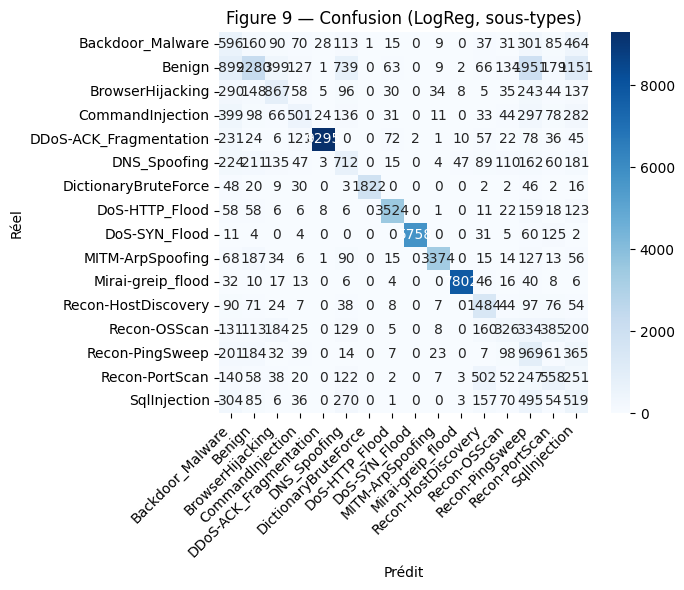

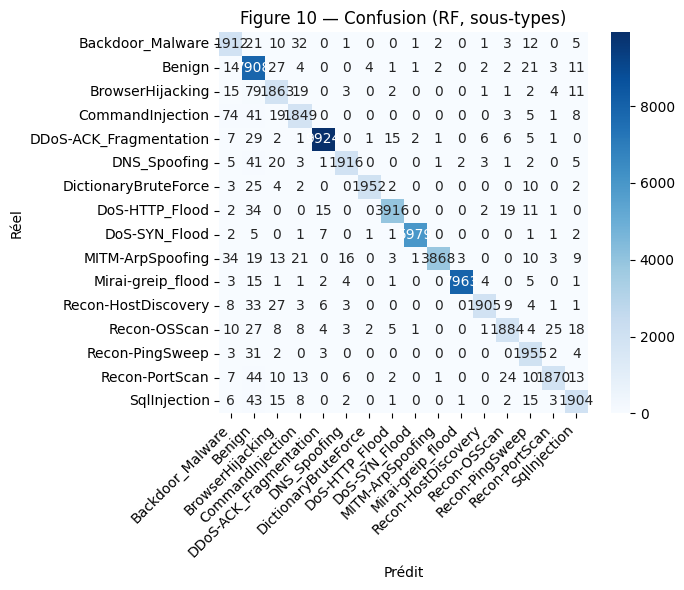

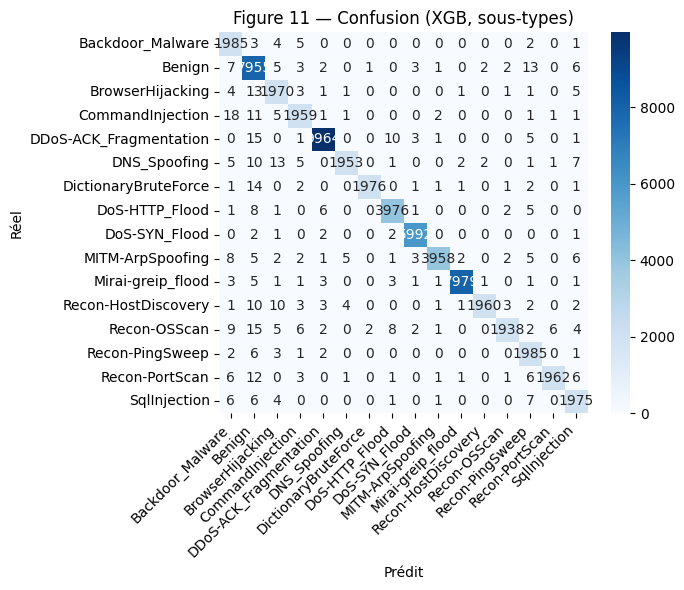

,scenario,title,prec_macro,rec_macro,prec_weighted,rec_weighted,auprc_macro_ovr,balanced_acc,mcc
0,Sous-types,Subtype - LogisticRegression,0.583367,0.565682,0.733843,0.673117,0.574896,0.565682,0.647220
1,Sous-types,Subtype - RandomForest,0.968907,0.963986,0.976627,0.976133,0.990701,0.963986,0.973697
2,Sous-types,Subtype - XGBoost (hist),0.988872,0.987614,0.991525,0.991450,0.999091,0.987614,0.990572


In [33]:
st_results = []
artifacts = {}



lr_st = LogisticRegression(max_iter=4000,class_weight="balanced",solver="saga",random_state=RANDOM_STATE)
lr_st.fit(st_scenario["X_train"], st_scenario["y_train"])
lr_pred = lr_st.predict(st_scenario["X_test"])
lr_proba = lr_st.predict_proba(st_scenario["X_test"])


rf_st = RandomForestClassifier(n_estimators=150,n_jobs=-1,random_state=RANDOM_STATE,class_weight="balanced_subsample")
rf_st.fit(st_scenario["X_train"], st_scenario["y_train"])
rf_pred = rf_st.predict(st_scenario["X_test"])
rf_proba = rf_st.predict_proba(st_scenario["X_test"])


xgb_st = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    objective="multi:softprob",
    num_class=len(st_scenario["classes"]),
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb_st.fit(st_scenario["X_train"], st_scenario["y_train"])
xgb_proba = xgb_st.predict_proba(st_scenario["X_test"])
xgb_pred = np.argmax(xgb_proba, axis=1)



artifacts["lr_pred"] = lr_pred
artifacts["rf_pred"] = rf_pred
artifacts["xgb_pred"] = xgb_pred

st_results.append(eval_multiclass(st_scenario["y_test"], lr_pred, title="Subtype - LogisticRegression", y_proba=lr_proba, classes=lr_st.classes_))
st_results.append(eval_multiclass(st_scenario["y_test"], rf_pred, title="Subtype - RandomForest", y_proba=rf_proba, classes=rf_st.classes_))
st_results.append(eval_multiclass(st_scenario["y_test"], xgb_pred, y_proba=xgb_proba, classes=np.arange(len(st_scenario["classes"])), title="Subtype - XGBoost (hist)"))
for r in st_results:
    r["scenario"] = st_scenario["name"]

plot_confusion_matrix(st_scenario["y_test"], artifacts["lr_pred"], class_names=st_scenario["classes"], title="Figure 9 — Confusion (LogReg, sous-types)")
plot_confusion_matrix(st_scenario["y_test"], artifacts["rf_pred"], class_names=st_scenario["classes"], title="Figure 10 — Confusion (RF, sous-types)")
plot_confusion_matrix(st_scenario["y_test"], artifacts["xgb_pred"], class_names=st_scenario["classes"], title="Figure 11 — Confusion (XGB, sous-types)")

st_df = pd.DataFrame(st_results)
st_df = st_df[["scenario", "title", "prec_macro", "rec_macro", "prec_weighted", "rec_weighted", "auprc_macro_ovr", "balanced_acc", "mcc"]]
st_df


In [34]:
fam_table = pd.DataFrame(fam_results)[[
    "title",
    "prec_macro",
    "rec_macro",
    "prec_weighted",
    "rec_weighted",
    "auprc_macro_ovr",
    "balanced_acc",
    "mcc",
]]

st_table = pd.DataFrame(st_results)[[
    "title",
    "prec_macro",
    "rec_macro",
    "prec_weighted",
    "rec_weighted",
    "auprc_macro_ovr",
    "balanced_acc",
    "mcc",
]]

fam_table
st_table

,title,prec_macro,rec_macro,prec_weighted,rec_weighted,auprc_macro_ovr,balanced_acc,mcc
0,Subtype - LogisticRegression,0.583367,0.565682,0.733843,0.673117,0.574896,0.565682,0.647220
1,Subtype - RandomForest,0.968907,0.963986,0.976627,0.976133,0.990701,0.963986,0.973697
2,Subtype - XGBoost (hist),0.988872,0.987614,0.991525,0.991450,0.999091,0.987614,0.990572


In [35]:
def pick_best(df, metric, higher_is_better=True):
    d = df.dropna(subset=[metric]).copy()
    idx = d[metric].idxmax() if higher_is_better else d[metric].idxmin()
    return d.loc[idx]

best_bin = pick_best(binary_table, metric="auprc")
best_fam = pick_best(fam_table, metric="balanced_acc")
best_st = pick_best(st_table, metric="balanced_acc") if "st_table" in globals() else None

rows = []
rows.append({
	"task": "Binary (Benign vs Attack)",
	"best_model": best_bin["title"],
	"metric": "AUPRC",
	"value": float(best_bin["auprc"]),
})
rows.append({
	"task": "Multiclass (Families)",
	"best_model": best_fam["title"],
	"metric": "Balanced Acc",
	"value": float(best_fam["balanced_acc"]),
})
rows.append({
	"task": "Multiclass (Subtypes)",
	"best_model": best_st["title"],
	"metric": "Balanced Acc",
	"value": float(best_st["balanced_acc"]),
})

pd.DataFrame(rows)

,task,best_model,metric,value
0,Binary (Benign vs Attack),Supervisé - XGBoost (CPU hist),AUPRC,0.999989
1,Multiclass (Families),Multiclass - XGBoost (hist),Balanced Acc,0.992400
2,Multiclass (Subtypes),Subtype - XGBoost (hist),Balanced Acc,0.987614


## 8. Conclusions

Points clés à rapporter :
- Le dataset est déséquilibré (Benign majoritaire), ce qui rend l’AUPRC particulièrement pertinente.
- Le split **par fichier** évite la fuite de données et rend l’évaluation plus crédible.
- Le projet couvre 3 niveaux complémentaires : **détecter** (binaire), **tracker haut niveau** (familles), **tracker fin** (sous-types).


## 8 bis. Conclusions cyber par niveau

**Partie 1 — Binaire (détecter)**
- Identifier le meilleur modèle (souvent XGBoost/RF) selon AUPRC et compromis FP/FN.
- Justifier l’usage des courbes PR (dataset déséquilibré) plutôt que l’accuracy.
- Interpréter les erreurs : faux positifs (alert fatigue) vs faux négatifs (attaques manquées).

**Partie 2A — Familles (tracker haut niveau)**
- Mettre en avant les familles les plus confondues via `top_confusions` et proposer une explication réseau (patterns proches).
- Comparer macro vs weighted : macro reflète l’équité entre familles rares/majoritaires.

**Partie 2B — Sous-types (tracker fin)**
- Montrer l’effet du déséquilibre et l’intérêt du filtrage + regroupement `Other` (évaluation stable, moins de classes fantômes).
- Discuter la limite : plus de granularité = plus de variance / besoin de données par sous-type.
